## Exploring the Data

In [2]:
import pandas as pd
import numpy as np
import pickle
#import preprocessor as p
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [2]:
# Reading in one time frame
df = pd.read_csv('data/camp_wf_clim.csv', delimiter = ';', error_bad_lines = False)

b'Skipping line 1478: expected 10 fields, saw 11\nSkipping line 2082: expected 10 fields, saw 11\nSkipping line 2715: expected 10 fields, saw 11\nSkipping line 2887: expected 10 fields, saw 11\nSkipping line 4732: expected 10 fields, saw 13\nSkipping line 7478: expected 10 fields, saw 12\nSkipping line 7543: expected 10 fields, saw 12\nSkipping line 8491: expected 10 fields, saw 11\nSkipping line 8847: expected 10 fields, saw 11\nSkipping line 9630: expected 10 fields, saw 11\nSkipping line 10010: expected 10 fields, saw 11\nSkipping line 10139: expected 10 fields, saw 11\nSkipping line 10167: expected 10 fields, saw 11\nSkipping line 10306: expected 10 fields, saw 11\nSkipping line 10517: expected 10 fields, saw 11\nSkipping line 11393: expected 10 fields, saw 11\nSkipping line 12215: expected 10 fields, saw 11\nSkipping line 12539: expected 10 fields, saw 11\n'


In [3]:
df.head()

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,NaN,2018-11-29 15:57,0,0,"Hey, I believe in climate change. I really do....",NaN,NaN,NaN,1.068293e+18,https://twitter.com/davetylerdat4/status/10682...
1,NaN,2018-11-29 15:56,1,2,Tejon Ranch’s Centennial: Just after the clima...,NaN,NaN,#,1.068293e+18,https://twitter.com/WilderUtopia/status/106829...
2,NaN,2018-11-29 15:49,0,0,California’s 2018 Wildfires Should Be a Turnin...,NaN,NaN,NaN,1.068291e+18,https://twitter.com/katslefty/status/106829101...
3,NaN,2018-11-29 15:40,1,3,"PG&E wildfire mishaps spark fury, profanity, p...",NaN,NaN,# # #,1.068289e+18,https://twitter.com/RisingTideNA/status/106828...
4,NaN,2018-11-29 15:30,0,2,RT+ @ ClimateNexus: Extreme weather events lik...,NaN,@,# # # #,1.068286e+18,https://twitter.com/HappsHealthHome/status/106...


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12922 entries, 0 to 12921
Data columns (total 10 columns):
username     0 non-null float64
date         12922 non-null object
retweets     12922 non-null int64
favorites    12922 non-null int64
text         12922 non-null object
geo          1 non-null object
mentions     3042 non-null object
hashtags     2921 non-null object
id           12921 non-null float64
permalink    12921 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 1009.7+ KB


## Connecting to Mongo 

In [4]:
from pymongo import MongoClient

In [5]:
config = {
    'host': 'xxxx',
    'username': 'brittany',
    'password': 'xxxx',
    'authSource': 'fires'
}

client = MongoClient(**config)

db = client.fires

In [6]:
db.list_collection_names()

['all_fires', 'shasta', 'sb', 'kincade', 'nca', 'camp']

In [7]:
df = db.all_fires

In [ ]:
df = pd.DataFrame(list(db.all_fires.find()))

In [ ]:
df.head()

In [220]:
with open('data/fire_raw.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

## Cleaning Pipeline

In [32]:
with open('data/fire_raw.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [33]:
# convert to string
df['text'] = [str(x) for x in df['text']]

In [34]:
# lower case
df['text'] = [x.lower() for x in df['text']]

In [35]:
# Use preprocessor to clean text of hashtags, links, emojis, etc
df['text'] = [p.clean(x) for x in df['text']]

In [36]:
# remove links
df['text'] = [x.split('http', 1)[0] for x in df['text']]
df['text'] = [x.split('pic.',1)[0] for x in df['text']]

In [37]:
# Remove rt using regex
test = [re.sub(r'(.*)\brt\b(.*)','',x) for x in df['text']]

In [38]:
df['text'] = test

In [39]:
df = df.drop(columns = [''])

In [40]:
# Get rid of duplicates
print(len(df['text'].unique()))
print(len(df['text']))

234267
343888


In [41]:
retweets = [x for x in df.groupby('text')['retweets'].sum()]
favorites = [x for x in df.groupby('text')['favorites'].sum()]

In [42]:
df = df.drop_duplicates(subset = 'text')

In [43]:
df['retweets'] = retweets
df['favorites'] = favorites

In [44]:
df.loc[(df['fire'] == 'kincade_1'), 'fire'] = ['kincade' for x in df.loc[(df['fire'] == 'kincade_1'), 'fire']]
df.loc[(df['fire'] == 'kincade_2'), 'fire'] = ['kincade' for x in df.loc[(df['fire'] == 'kincade_2'), 'fire']]

In [45]:
df['fire'].unique()

array(['shasta_2018', 'kincade', 'nca_2017', 'sb_2017', 'camp'],
      dtype=object)

In [46]:
# Remove punctuation
# Far as I can tell [%s] is the same as \s* 
df['text'] = [re.sub('[%s]' % re.escape(string.punctuation), '', text)  for text in df['text']]

In [47]:
# Removes text containing digits
df['text'] = [re.sub('\w*\d\w*', ' ', text) for text in df['text']]

In [50]:
copy_text = df['text']

## Exploring Stemming

- Stemming: Uses rough heuristics to reduce words to base 
- Lemmatization: Uses vocabulary and morphological analysis

- PorterStemmer, LancasterStemmer, SnowballStemmer 
- WordNetLemmatizer

In [74]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stemmerl = LancasterStemmer()
stemmerp = PorterStemmer()
stemmers = SnowballStemmer('english')
stemmerwn = WordNetLemmatizer()

In [78]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brittb28/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [52]:
copy_text = [stemmer.stem(tweet) for tweet in copy_text]

In [55]:
copy_text[2456]

'this is a secondary argument for biomass power it gives an economic reason to remove the crappy trees that can fuel wildfires this isnt really an issue in the northeast but it sure is out west …'

In [61]:
res = re.findall(r'\w+', copy_text[2456]) 

In [63]:
print([stemmer.stem(word) for word in res])

['thi', 'is', 'a', 'second', 'argu', 'for', 'biomass', 'pow', 'it', 'giv', 'an', 'econom', 'reason', 'to', 'remov', 'the', 'crappy', 'tre', 'that', 'can', 'fuel', 'wildfir', 'thi', 'isnt', 'real', 'an', 'issu', 'in', 'the', 'northeast', 'but', 'it', 'sur', 'is', 'out', 'west']


In [65]:
print([stemmerp.stem(word) for word in res])

['thi', 'is', 'a', 'secondari', 'argument', 'for', 'biomass', 'power', 'it', 'give', 'an', 'econom', 'reason', 'to', 'remov', 'the', 'crappi', 'tree', 'that', 'can', 'fuel', 'wildfir', 'thi', 'isnt', 'realli', 'an', 'issu', 'in', 'the', 'northeast', 'but', 'it', 'sure', 'is', 'out', 'west']


In [73]:
print([stemmers.stem(word) for word in res])

['this', 'is', 'a', 'secondari', 'argument', 'for', 'biomass', 'power', 'it', 'give', 'an', 'econom', 'reason', 'to', 'remov', 'the', 'crappi', 'tree', 'that', 'can', 'fuel', 'wildfir', 'this', 'isnt', 'realli', 'an', 'issu', 'in', 'the', 'northeast', 'but', 'it', 'sure', 'is', 'out', 'west']


In [79]:
print([stemmerwn.lemmatize(word) for word in res])

['this', 'is', 'a', 'secondary', 'argument', 'for', 'biomass', 'power', 'it', 'give', 'an', 'economic', 'reason', 'to', 'remove', 'the', 'crappy', 'tree', 'that', 'can', 'fuel', 'wildfire', 'this', 'isnt', 'really', 'an', 'issue', 'in', 'the', 'northeast', 'but', 'it', 'sure', 'is', 'out', 'west']


Another thing to consider is parts of speach. This can be done via the word net lemmatizer and mapped back onto the words...or there's this other cool package

In [80]:
import spacy

In [81]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [85]:
new = nlp(copy_text[2456])
print([word.lemma_ for word in new])

['this', 'be', 'a', 'secondary', 'argument', 'for', 'biomass', 'power', '-PRON-', 'give', 'an', 'economic', 'reason', 'to', 'remove', 'the', 'crappy', 'tree', 'that', 'can', 'fuel', 'wildfire', 'this', 'be', 'not', 'really', 'an', 'issue', 'in', 'the', 'northeast', 'but', '-PRON-', 'sure', 'be', 'out', 'west', '…']


**Using Spacy it is the best**

In [92]:
new_copy = []
for tweet in copy_text:
    new = nlp(tweet)
    new_copy.append([" ".join([token.lemma_ for token in new])])

In [98]:
df['text'] = [tweet[0] for tweet in df['text']]

In [99]:
with open('data/fire_clean.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

## Word Similarity - Spelling

In [280]:
with open('data/fire_clean.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [6]:
from textblob import TextBlob

In [ ]:
df['text_copy'] = [TextBlob(x).correct() for x in df['text']] 

In [10]:
df.head()

,_id,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,fire,text_copy
0,5dcb3fc81641db7377bb1e4e,,2018-09-19 16:59,4802,6465,large wildfire in california history officiall...,,,#,1.04256e+18,https://twitter.com/mdrtindia/status/104256384...,shasta_2018,"(l, a, r, g, e, , w, i, l, d, f, i, r, e, , ..."
1,5dcb3fc81641db7377bb1e4f,,2018-09-19 16:59,0,2,have -PRON- see the new nfpa ’s wildfire and f...,,,,1.04256e+18,https://twitter.com/JCFD3FireInfo/status/10425...,shasta_2018,"(h, a, v, e, , -, P, R, O, N, -, , s, e, e, ..."
2,5dcb3fc81641db7377bb1e50,,2018-09-19 16:59,7,8,rattlesnake creek fire unofficial wildfire upd...,,,,1.04256e+18,https://twitter.com/FireUnofficial/status/1042...,shasta_2018,"(r, a, t, t, l, e, s, n, a, k, e, , c, r, e, ..."
3,5dcb3fc81641db7377bb1e51,,2018-09-19 16:57,0,1,wyoming ’s martencreekfire wildfire wyfire wyb...,,,# # # # #,1.04256e+18,https://twitter.com/RSFireNerd/status/10425634...,shasta_2018,"(w, y, o, m, i, n, g, , ’, s, , m, a, r, t, ..."
4,5dcb3fc81641db7377bb1e52,,2018-09-19 16:56,0,0,honey cs video for numb drop soon queenhoneyc ...,,@,,1.04256e+18,https://twitter.com/HONEYCOCAINA_/status/10425...,shasta_2018,"(h, o, n, e, y, , c, s, , v, i, d, e, o, , ..."


## Get Sentiment from Tweets

In [11]:
from tqdm import tqdm

In [31]:
string = "Yo quiero fresas"
analysis = TextBlob(string)
lang = analysis.detect_language()
print(lang)
translate = str(analysis.translate(from_lang='es', to ='en'))

es


In [32]:
translate

'I want strawberries'

In [34]:
list_ = []
list_.append(analysis)

Bin the data 

In [38]:
df['fire'].value_counts()

kincade        80831
nca_2017       62624
camp           37886
shasta_2018    35443
sb_2017        17483
Name: fire, dtype: int64

In [47]:
df.columns

Index(['_id', 'username', 'date', 'retweets', 'favorites', 'text', 'geo',
       'mentions', 'hashtags', 'id', 'permalink', 'fire', 'sentiment'],
      dtype='object')

In [48]:
df = df.drop(columns = ['username', 'geo', 'mentions', 'hashtags', 'permalink', '_id'])

In [95]:
kincade_split = df.loc[df['fire'] == 'kincade', :].reset_index()
nca_split = df.loc[df['fire'] == 'nca_2017', :].reset_index()
camp_split = df.loc[df['fire'] == 'camp', :].reset_index()
shasta_split = df.loc[df['fire'] == 'shasta_2018', :].reset_index()
sb_split = df.loc[df['fire'] == 'sb_2017', :].reset_index()

In [96]:
kincade_split = kincade_split[0:5000]
nca_split = nca_split[0:10000]
camp_split = camp_split[0:10000]
shasta_split = shasta_split[0:10000]
sb_split = sb_split[0:10000]

In [85]:
kincade_split = kincade_split[0:2465].reset_index()

In [87]:
nca_split = nca_split[0:5000].reset_index()

In [ ]:
sentiment_lst = []
sent_num = []
language = []
spell_trans_lst = []
analysis = []
for i,tweet in tqdm(enumerate(kincade_split['text'])):
    if len(tweet) <= 3:
        kincade_split.drop(i)
    else:
        ana = TextBlob(tweet)
        analysis.append(ana)
        sent_num.append(ana.sentiment.polarity)
        lang = ana.detect_language()
        language.append(lang)
        if lang != 'en':
            try:
                translate = str(ana.translate(from_lang=lang, to ='en'))
                new_analysis = TextBlob(translate)
                spell_trans = new_analysis.correct()
            except:
                spell_trans = np.nan
        else:
            spell_trans = ana.correct()
        spell_trans_lst.append(spell_trans)
        if ana.sentiment.polarity > 0:
            sentiment = 'positive'
        elif ana.sentiment.polarity == 0:
            sentiment = 'neutral'
        else:
            sentiment = 'negative'
        sentiment_lst.append(sentiment)

In [106]:
mask = kincade_split.loc[kincade_split['text'].str.len() <=3, :]
kincade_split = kincade_split.drop(mask.index)

In [133]:
kincade_split = kincade_split.reset_index()

In [142]:
bottom = kincade_split.loc[0:2463,:]

In [143]:
top = kincade_split.loc[2465:,:]

In [147]:
df_kincade_5000 = pd.concat([top, bottom], ignore_index= True)

In [158]:
df_kincade_5000['sentiment'] = sentiment_lst
df_kincade_5000['sent_num'] = sent_num
df_kincade_5000['language'] = language
df_kincade_5000['spell_trans'] = spell_trans_lst
df_kincade_5000['analysis'] = analysis

In [170]:
df_kincade_5000['sent_num'] = [float(x) for x in df_kincade_5000['sent_num']]
df_kincade_5000['language'] = [str(x) for x in df_kincade_5000['language']]
df_kincade_5000 = df_kincade_5000.drop(columns = ['analysis', 'spell_trans'], axis = 1)

In [172]:
df_kincade_5000 = df_kincade_5000.drop(columns = ['level_0', 'index'], axis = 1)

In [178]:
df_kincade_5000.loc[0,'text']

'citidiot do not understand forest management or how important -PRON- be to remove natural wildfire fuel dead tree leave and other flammable debris never let a predictable and natural disaster go to waste though'

In [161]:
df_kincade_5000['language'].value_counts()

en       4901
fr         28
ja         17
ne          8
es          8
de          8
pt          7
zh-CN       3
ru          2
ar          2
tl          2
hr          1
th          1
mi          1
hmn         1
nl          1
hi          1
sl          1
da          1
co          1
ms          1
Name: language, dtype: int64

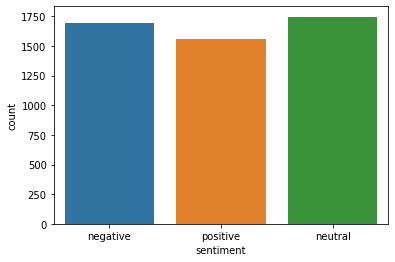

In [162]:
sns.countplot(df_kincade_5000['sentiment'])

In [179]:
with open('data/df_kincade_5000.pickle', 'wb') as to_write:
    pickle.dump(df_kincade_5000, to_write)

In [278]:
with open('data/not_equal.pickle', 'rb') as to_read:
    df_nca_ne = pickle.load(to_read)

In [282]:
nca_split = df.loc[df['fire'] == 'nca_2017', :].reset_index(drop = True)

In [288]:
nca_split = nca_split.loc[0:5000,:].reset_index(drop = True)

In [296]:
mask = nca_split.loc[nca_split['text'].str.len()<=3,:]
nca_split = nca_split.drop(mask.index)

In [301]:
nca_split = nca_split.reset_index(drop = True)

In [298]:
df_nca_ne

,sentiment,sent_num,language,spell_trans
0,neutral,0.000000,en,mind horse escape wildlife in backseat of car
1,neutral,0.000000,en,bc news california wildlife destroy legal ma...
2,neutral,0.000000,en,-PRON- definitely belong in an asylum -PRON- j...
3,neutral,0.000000,en,wildlife evacuation lift road open in papa cou...
4,neutral,0.000000,en,california launch wildlife clean ' for the rec...
...,...,...,...,...
4994,positive,0.100000,en,wildlife burn near strawberry reservoir threat...
4995,neutral,0.000000,en,wildlife in utah force evacuation threaten str...
4996,negative,-0.013333,en,nigerianewsdesk southern california on the bri...
4997,neutral,0.000000,en,news via foxes french authority get corsican...


In [303]:
nca_2017_5000 = pd.concat([nca_split,df_nca_ne], axis = 1 )

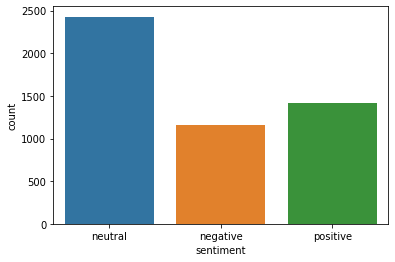

In [305]:
sns.countplot(nca_2017_5000['sentiment'])

In [307]:
nca_2017_5000['language'].value_counts()

en       4896
ja         31
pt         11
es          7
nl          4
ko          4
tl          4
it          3
lb          3
ne          3
de          3
st          3
th          3
hr          3
fr          2
hi          2
ca          2
fy          2
sw          1
zu          1
fa          1
sk          1
co          1
gl          1
zh-TW       1
ceb         1
ru          1
cy          1
eo          1
ar          1
vi          1
Name: language, dtype: int64

In [304]:
with open('data/nca_2017_5000.pickle', 'wb') as to_write:
    pickle.dump(nca_2017_5000, to_write)

## Some EDA of other features

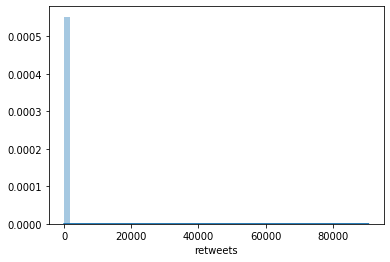

In [286]:
sns.distplot(df['retweets'])

In [308]:
df['retweet_binary'] = pd.cut(df['retweets'], bins = [0, 1, 1000000], labels = [0,1])

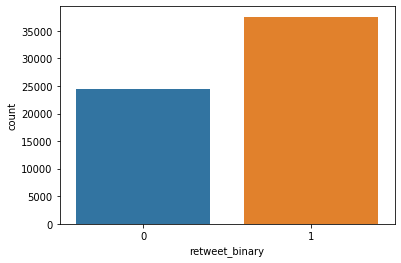

In [309]:
sns.countplot(df['retweet_binary'])